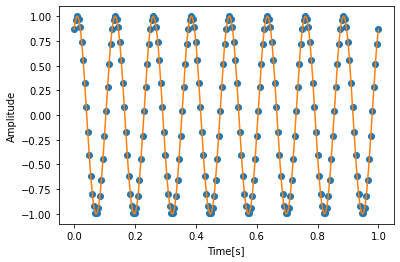

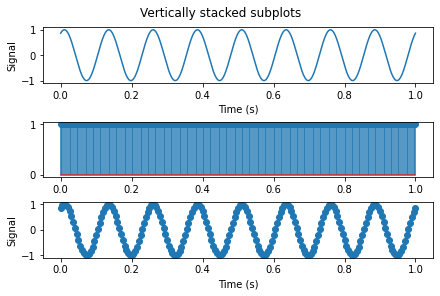

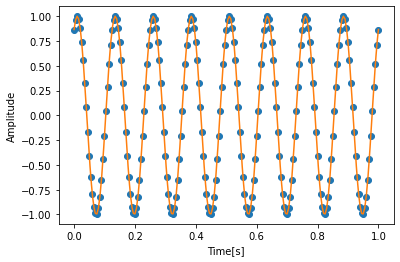

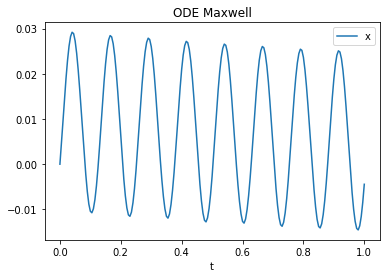

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

#define excitation varibales
f_s = 200               # Sample frequency
T_s = 1/f_s             # Sampling time
T = 1                  # Time interval of total test
f_I = 8                 # Identification excitation frequency
phi = np.pi/3           # Signal phase
nCT = 10                # Oversampling points for continuous time plots

NDT=T*f_s               # Number of discrete points
NCT=T*f_s*nCT           # Number of cointinuous point
t_DT= np.arange(0, T+T_s, T_s)              # Discrete-time vector
t_CT= np.arange(0, T+(T_s/nCT), (T_s/nCT))  # Continuous-time vector

def sine (period):
    return np.sin(period)

u_DT=sine(2*np.pi*f_I*t_DT+phi)
u_CT=sine(2*np.pi*f_I*t_CT+phi)

plt.plot(t_DT, u_DT, "o", t_CT, u_CT, "-")
#ax3.suptitle('Continuous signal with sampled points')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

fig2, (ax0, ax1,ax2) = plt.subplots(3, 1, layout='constrained')
fig2.suptitle('Vertically stacked subplots')
ax0.plot(t_CT, u_CT,'-')
ax1.stem(t_DT,np.ones(np.size(t_DT)))
ax2.plot(t_DT,u_DT,'o')

for ax in ax0,ax2:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal')

plt.show()

def DAC_0(u_discrete, sample_time, time_range):
    u_test = []
    for i in range(len(time_range)):
        x = int(time_range[i]//sample_time)
        u_test.append(u_discrete[x])
    return np.array(u_test)



# run the function
u_T = DAC_0(u_DT, T_s, t_CT)

# Alternative calculation of u_t, by use of scipy interpolation, kind is 0,2 and all odd numbers
u_interp=interp1d(t_DT,u_DT,kind=1)
u_t_interp = u_interp(t_CT)


plt.plot(t_DT, u_DT, "o", t_CT, u_t_interp, "-")
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

def gamma_dot(t):
    return u_interp(t)

# waarom moet je de waardes voor
# tau_dot=G*gamma_dot(t) -1/lambda *tau
def ODE_maxwell(t, tau, L,G):
    #L,G=args
    return G*gamma_dot(t) - tau/L

sol = solve_ivp(ODE_maxwell, [0, T], [0], args=(1.5, 1), t_eval=t_DT)


plt.plot(np.squeeze(t_DT), np.squeeze(sol.y))
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=False)
plt.title('ODE Maxwell')
plt.show()

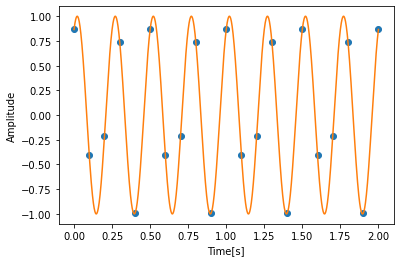

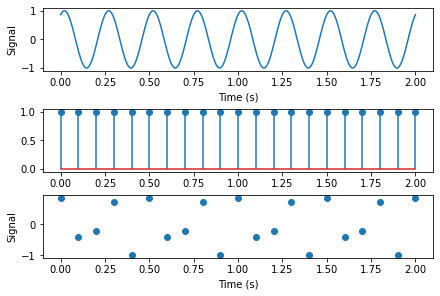

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

#define excitation varibales
f_s = 10               # Sample frequency [Hz]
T_s = 1/f_s             # Sampling time [s]
T = 2                  # Time interval of total test [s]
f_I = 4                 # Interest excitation frequency [Hz]
phi = np.pi/3           # Signal phase
nCT = 100                # Oversampling points for continuous time plots

NDT=T*f_s               # Number of discrete points
NCT=T*f_s*nCT           # Number of cointinuous point
t_DT= np.arange(0, T+T_s, T_s)              # Discrete-time vector
t_CT= np.arange(0, T+(T_s/nCT), (T_s/nCT))  # Continuous-time vector

def sine (period):
    return np.sin(period)

u_D=sine(2*np.pi*f_I*t_DT+phi)
u_C=sine(2*np.pi*f_I*t_CT+phi)

plt.plot(t_DT, u_D, "o", t_CT, u_C, "-")
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

fig, (ax0, ax1,ax2) = plt.subplots(3, 1, layout='constrained')
ax0.plot(t_CT, u_C,'-')
ax1.stem(t_DT,np.ones(np.size(t_DT)))
ax2.plot(t_DT,u_D,'o')

for ax in ax0,ax2:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal')

plt.show()